<a href="https://colab.research.google.com/github/Daragh-Sweeney/AlbumCoverGenerator/blob/main/AlbumCoverGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to the Album Cover Generator**

Before we get started, here are a few important points:

- **Pretrained Models:** You can find pretrained models for the album cover generator on GitHub at [this link](https://github.com/Daragh-Sweeney/Models-for-Album-cover-generator.git). Please ensure you place these models in the root directory of your Google Drive if you intend to use them for creating new album covers.
  
- **Creating a New Model:** If you prefer to create a new model instead of using the pretrained ones, simply run the code without any saved models. A new model will be automatically created in the same location. However, please note that accessing the database requires a Kaggle username and key.

**Instructions:**

Please execute the code blocks in sequence as outlined below:

1. **Libraries and Functions:** Download and install the necessary libraries for the project.
  
2. **Genre Classification by CNN:** Create a new Convolutional Neural Network (CNN) model for genre classification, this will not run unless called later on.
  
3. **Album Cover Generation using GAN:** Create a new Generative Adversarial Networks (GANs) for album cover generation, this also will not run unless called later on.
  
4. **Get Predicted Label:** Retrieve the predicted label for the generated album cover. This will try and use a pretrained model but if not available will call step 2.
  
5. **Confirm Selected Genre:** Confirm with user if the selected genre is correct.
  
6. **Generate Album Cover Art:** Generate album cover art based on the selected genre. This will try and use a pretrained model but if not available will call step 3 with the input genre.
  

Feel free to reach out if you have any questions or encounter any issues. Let's create some amazing album covers together!

In [ ]:
#@title 1. Libraries and Functions
# Install and import the necessary libraries
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
import librosa
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from IPython.display import Image
from PIL import Image, ImageFilter
from google.colab import drive
from google.colab import files

# Mount Google Drive to access saved models
drive.mount('/content/drive')

# Function to get the default device (GPU if available, else CPU)
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to move tensors to the specified device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Class to wrap the dataloader and move data to device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Set the default device
device = get_default_device()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title 2. Genre Classification by CNN

#Function to sample a 5-second section of audio and create a spectrogram
def getSpectogram(filePath, duration=5, noise_factor=0.005):
    y, sr = librosa.load(filePath, duration=duration)
    y_noisy = y + noise_factor * np.random.normal(size=y.shape)
    mel_spec = librosa.feature.melspectrogram(y=y_noisy, sr=sr, n_mels=64)
    total_frames = mel_spec.shape[1]
    start_idx = random.randint(0, max(total_frames - 256, 0))
    mel_spec_slice = mel_spec[:, start_idx:start_idx + 256]
    mel_spec_db = librosa.power_to_db(mel_spec_slice, ref=np.max)
    return mel_spec_db

# Function to plot the Training vs Validation Loss and Training vs Validation Accuracy
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


# Function to create genre classifier model
def createGenreClassifier():

  dataset_url = 'https://www.kaggle.com/daraghsweeney/spotify-tracks' # Download the database from kaggle
  od.download(dataset_url)
  data_dir = '/content/spotify-tracks/tracks'

  # Define the percentage split for training, validation, testing and number of samples
  train_ratio = 0.8
  val_ratio = 0.1
  test_ratio = 0.1
  num_files_per_category = 400

  # Define empty lists to store file paths and labels for training, validation, and testing
  train_files,test_files,val_files = [],[],[]
  train_labels,test_labels,val_labels = [],[],[]


  # Traverse through each file in subdirectory
  for label, genre in enumerate(categories):
      genre_dir = os.path.join(data_dir, genre)

      # Get a list of all files in the genre subdirectory
      files = os.listdir(genre_dir)
      np.random.shuffle(files)

      # Take the first 100 files from each category
      files = files[:num_files_per_category]

      # Calculate the split indices
      num_files = len(files)
      train_end = int(train_ratio * num_files)
      val_end = int((train_ratio + val_ratio) * num_files)

      # Append file paths and labels to the appropriate lists based on the split indices
      for i, file in enumerate(files):

          file_path = os.path.join(genre_dir, file)
          specto = getSpectogram(file_path)

          # I found there are somtimes issues with the Spectogram sizes, I skip these
          if specto.shape != (64, 216):
            print(f"Warning: Spectrogram size for file '{file}' is not correct. Skipping...")
            continue

          if i < train_end:
              train_files.append(specto)
              train_labels.append(label)

          elif train_end <= i < val_end:
              val_files.append(specto)
              val_labels.append(label)

          else:
              test_files.append(specto)
              test_labels.append(label)


# Define the Architecture for genre model
  genre_model = models.Sequential([
      layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 216, 1)),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)),
      layers.MaxPooling2D((2, 2)),
      layers.BatchNormalization(),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(16, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(8, activation='softmax')
  ])

  # Define the optimizer and Compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
  genre_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Train the model and plot graphs
  history = genre_model.fit(np.array(train_files), np.array(train_labels), epochs=150, batch_size=32,
                            validation_data=(np.array(val_files), np.array(val_labels)))
  plot_history(history)

  # Save the model in the users drive
  model_path = '/content/drive/My Drive/Classifier/genre_model.h5'
  genre_model.save(model_path)


In [ ]:
#@title 3. Album Cover Generation using GAN

# Plot the Discriminator and Generator losses
def plot_losses(losses_g, losses_d, real_scores, fake_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_g, label='Generator Loss', alpha=0.5)
    plt.plot(losses_d, label='Discriminator Loss', alpha=0.5)
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the real scores vs the fake scores
def plot_scores(real_scores, fake_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(real_scores, label='Real Scores', alpha=0.5)
    plt.plot(fake_scores, label='Fake Scores', alpha=0.5)
    plt.title('Real and Fake Scores')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.show()


def createAlbumCoverGAN(genre):
  # Use Kaggle to download album cover art
  dataset_url = 'https://www.kaggle.com/daraghsweeney/spotify-album-covers'
  od.download(dataset_url)

  # Import the category dataset into PyTorch
  data_dir = '/content/spotify-album-covers/album_covers'
  catagory_dir = os.path.join(data_dir, genre)
  dataset = ImageFolder(catagory_dir)


  batch_size = 64
  latent_size = 128
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

  # This is used if the image is in a
  train_ds = ImageFolder(catagory_dir, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


  # The following functions allow us to display a batch of images
  def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

  def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

  def show_batch(dl, nmax=64):
    for images, _ in dl:
      show_images(images, nmax)
      break

  # We show the first batch that will be used for training
  show_batch(train_dl)
  train_dl = DeviceDataLoader(train_dl, device)

  # Discriminator model
  discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid())

  discriminator = to_device(discriminator, device)

  # Generator model
  generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
  )

  # Create a random latent tensor to be passed into the generator
  xb = torch.randn(batch_size, latent_size, 1, 1)
  fake_images = generator(xb)

  def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

  generator = generator.to(device)

  def train_generator(opt_g):
  # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()
    return loss.item()

  sample_dir = 'generated'
  os.makedirs(sample_dir, exist_ok=True)

  def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
      fig, ax = plt.subplots(figsize=(8, 8))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


  fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
  save_samples(0, fixed_latent)

  def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    # Losses & scores
    losses_g_avg, losses_d_avg, real_scores_avg, fake_scores_avg = [],[],[],[]

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):

      losses_g, losses_d, real_scores, fake_scores = [],[],[],[]

      for real_images, _ in tqdm(train_dl):
        # Train discriminator and generator
        loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)


      # I want to get the average values for epoch
      losses_g_avg.append(sum(losses_g) / len(losses_g))
      losses_d_avg.append(sum(losses_d) / len(losses_d))
      real_scores_avg.append(sum(real_scores) / len(real_scores))
      fake_scores_avg.append(sum(fake_scores) / len(fake_scores))

      # Log losses & scores (last batch)
      print("Epoch [{}/{}], "
      "loss_g: {:.4f}, "
      "loss_d: {:.4f}, "
      "real_score: {:.4f}, "
      "fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

      # Save generated images
      save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g_avg, losses_d_avg, real_scores_avg, fake_scores_avg


  # Create the model with the following hyperparameters
  lr = 0.00035
  epochs = 200
  history = fit(epochs, lr)
  losses_g, losses_d, real_scores, fake_scores = history


  # Plot losses and scores
  plot_losses(losses_g, losses_d, real_scores, fake_scores)
  plot_scores(real_scores, fake_scores)

  # Save the generated model
  torch.save(generator.state_dict(), '/content/drive/My Drive/generators/'+Category+'_G.pth')
  torch.save(discriminator.state_dict(), '/content/drive/My Drive/discriminators/'+Category+'_D.pth')





Please upload a song file:


Saving Trumpet Voluntary.mp3 to Trumpet Voluntary.mp3
1/1 [==============================] - 0s 124ms/step
Predicted genre: classical


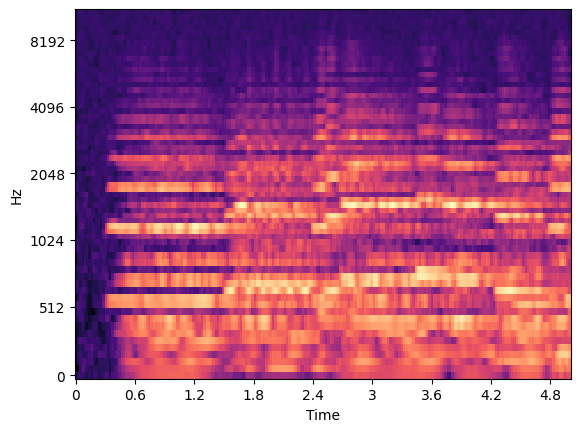

In [ ]:
#@title 4. Input song and get predicted Genre


categories = ["rock","pop","classical","hiphop","country","latin","edm_dance","jazz"]

# Define the file path to the Pretrained CNN
model_path = '/content/drive/My Drive/Classifier/genre_model.h5'

# This code will be used to classify song if model is available
def classifysong():
  loaded_model = load_model(model_path)

  # Prompt the user to upload a file
  print("Please upload a song file:")
  uploaded_file = files.upload()

  # Get the file name of the uploaded song
  file_name = list(uploaded_file.keys())[0]

  # Extract spectrogram from the user-input song
  new_spectrogram = getSpectogram(file_name)

  librosa.display.specshow(new_spectrogram,  x_axis='time', y_axis='mel')

  # Convert the prediction to a genre label and get the genre from list
  prediction = loaded_model.predict(np.expand_dims(new_spectrogram, axis=0))
  predicted_genre_index = np.argmax(prediction)
  predicted_genre = categories[predicted_genre_index]

  print("Predicted genre:", predicted_genre)
  return predicted_genre


# If the model is available use it for classification
if os.path.exists(model_path):
  predicted_genre = classifysong()

# If there is no model already there then we create a new one
else:
  print("Model does not exist so lets create a new one.")
  print("Please rerun this cell after the model has been created.")
  createGenreClassifier()
  predicted_genre = classifysong()




In [ ]:
#@title 5. Confirm selected genre is correct


import ipywidgets as widgets

# Define a variable to store the selected genre
selected_genre = predicted_genre  # Initialize with the predicted genre
print('The predicted label for this song is :'+str(predicted_genre))
print('Please leave dropdown if this is correct, otherwise update')


# Dropdown widget with preset predicted genre and all available genres
genre_dropdown = widgets.Dropdown(
    options=categories,
    value=predicted_genre,
    description='Genre:',
    disabled=False,
)

# Function to handle dropdown value change
def on_dropdown_change(change):
    global selected_genre  # Use the selected_genre variable defined outside the function
    selected_genre = change.new  # Update the selected_genre variable with the new value
    print("Updated genre:", selected_genre)  # Print the updated genre value

# Assign the function to be called when dropdown value changes
genre_dropdown.observe(on_dropdown_change, names='value')

# Display the dropdown widget
display(genre_dropdown)


The predicted label for this song is :classical
Please leave dropdown if this is correct, otherwise update


Dropdown(description='Genre:', index=2, options=('rock', 'pop', 'classical', 'hiphop', 'country', 'latin', 'ed…

Updated genre: pop


Now that we have the Genre we, can develop an album cover

pop


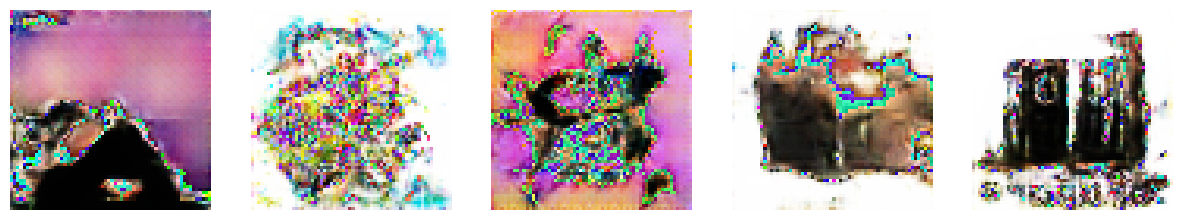

Wow your images look amazing, you can download in the files section of colab!


In [ ]:
#@title 6. Generate Album Cover Art

Category = selected_genre
print(Category)

# Load the pretrained generator and discriminator
generator_path = '/content/drive/My Drive/generators/'+Category+'_G.pth'
discriminator_path = '/content/drive/My Drive/discriminators/'+Category+'_D.pth'


# Check if both paths exist if they do use the pretrained models
# Else create a new model with the input genre
if os.path.exists(generator_path) and os.path.exists(discriminator_path):

  generator_checkpoint = torch.load(generator_path, map_location=torch.device('cpu'))
  discriminator_checkpoint = torch.load(discriminator_path, map_location=torch.device('cpu'))

  # Instantiate the generator and discriminator models
  latent_size = 128
  generator_load = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())

  discriminator_load = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid())


  # Load the state dictionarys into the generator and discriminator models
  generator_load.load_state_dict(generator_checkpoint)
  generator_load.eval()
  discriminator_load.load_state_dict(discriminator_checkpoint)
  discriminator_load.eval()
  generator_load = generator_load.to(device)
  discriminator_load = discriminator_load.to(device)

  # Generate 1000 images
  num_images = 1000
  top_images = [(float('-inf'), None)] * 5  # Initialize a list to store the top 5 images and their scores

  for _ in range(num_images):

      # Generate image
      latent_vector = torch.randn(1, latent_size, 1, 1).to(device)
      with torch.no_grad():
          generated_image = generator_load(latent_vector)

      # Pass the generated image through the discriminator
      generated_image = generated_image.to(device)
      discriminator_score = discriminator_load(generated_image)

      # Update the top images list
      top_images.sort(key=lambda x: x[0])  # Sort the list based on scores
      if discriminator_score > top_images[0][0]:
          top_images[0] = (discriminator_score, generated_image.clone().cpu())


  # Convert to PIL images
  pil_images = [tt.transforms.ToPILImage()(image.squeeze(0)) for _, image in top_images]

  # Display the top 5 generated images
  fig, axes = plt.subplots(1, 5, figsize=(15, 3))
  for i, image in enumerate(pil_images):
      axes[i].imshow(image)
      axes[i].axis('off')
  plt.show()

  print("Wow your images look amazing, you can download in the files section of colab!")
  # Save the top generated images to files
  for i, image in enumerate(pil_images):
      image.save(f'top_generated_image_{i}.png')

# If no model is available we create a new one with the genre passed in
else:
    print("One or both paths do not exist.")
    createAlbumCoverGAN(Category)